# Map velocities using geogrid and autoRIFT with custom parameters

_Last modified on 2022-10-04 by jukesliu@u.boisestate.edu._

Majority of the code is borrowed from testGeogrid_ISCE.py and testautoRIFT_ISCE.py from the autoRIFT GitHub repository (https://github.com/nasa-jpl/autoRIFT/). Requires ISCE and autoRIFT to be installed.

Change the kernel to __newautoriftenv__.

In [1]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from scipy.interpolate import interp2d

import isce
from contrib.geo_autoRIFT.geogrid import Geogrid, GeogridOptical
from iscesys.Component.ProductManager import ProductManager as PM
from isceobj.Orbit.Orbit import Orbit
from osgeo import gdal, osr
import struct
# import re
from datetime import date
import datetime
import xml.etree.ElementTree as ET
# import urllib.request
from components.contrib.geo_autoRIFT.autoRIFT import autoRIFT_ISCE
import isceobj
import time
import subprocess
import cv2
import scipy.io as sio
os.environ['PROJ_LIB'] = '//Users/jukesliu/opt/anaconda3/envs/newautoriftenv/share/proj'

from autorift_utilities import *

gdal.AllRegister() # register all GDAL drivers

Using default ISCE Path: /Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


# 1) Resample DEM and other input rasters to the desired chip size

### Recommended chip size is >= 16*pixel_resolution

#### Customizable parameters for geogrid:

    dhdx, dhdy:              x/y local surface slope maps (unitless)
    vx,vy:                   x/y reference velocity maps (in units of m/yr)
    srx, sry:                x/y velocity search range limit maps (in units of m/yr)
    csminx, csminy:          x/y chip size minimum maps (in units of m; constant ratio between x and y)
    csmaxx, csmaxy:          x/y chip size maximum maps (in units of m; constant ratio between x and y)
    ssm:                     stable surface mask (boolean)

In [2]:
######### ENTER CHIP SIZE, DEM INFO, AND REFERENCE VELOCITY INFO ########### 
CHIPSIZE_M = 100 # enter in desired grid size in meters (default is 32 pixels)

# enter in the path to your best DEM over the region
dempath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/'
demname = 'IfSAR_5m_DSM_clipped.tif'

# path to the reference files for geogrid (vx, vy, ssm)
refvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/' 
vx_fname = 'vx_cropped.tif' # name of reference vx file
vy_fname = 'vy_cropped.tif' # name of reference vy file

sr_scaling = 16 # multiply by vx and vy to generate search range limits
############################################################################

In [3]:
# PROCESS ALL INPUTS USING FUNCTION:
# ONE CHIPSIZE:
# generate_geogrid_inputs(CHIPSIZE_M, dempath, demname, refvpath, vx_fname, vy_fname, sr_scaling)

# # # MANY CHIPSIZES:
# # for CHIPSIZE_M in [100,150,160,200,300, 350, 400]:
# #     generate_geogrid_inputs(CHIPSIZE_M, dempath, demname, refvpath, vx_fname, vy_fname, sr_scaling)
# #     print(); print()

In [4]:
# Read and grab info from your DEM
refdem = rio.open(dempath+demname) # open DEM using rasterio
elev = refdem.read(1) # read in the first and only band (elevations)

# grab the x and y grid values from the DEM:
dem_x = np.linspace(refdem.bounds.left, refdem.bounds.right, num=np.shape(elev)[1])
dem_y = np.linspace(refdem.bounds.top, refdem.bounds.bottom, num=np.shape(elev)[0])

# grab the resampled x and y grid values from the DEM
new_x = np.arange(refdem.bounds.left, refdem.bounds.right, CHIPSIZE_M)
new_y = np.arange(refdem.bounds.top, refdem.bounds.bottom, -CHIPSIZE_M)

In [5]:
dem_outfile = 'IfSAR_'+str(CHIPSIZE_M)+'m_DSM_clipped.tif' # generate new filename

if not os.path.exists(dempath+dem_outfile): # if the resampled DEM does not exist already
    # Create thew new x and y grid values using DEM bounds and the chipsize
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_resamp.shape)
    
    # Resample to your new DEM bounds
    f = interp2d(dem_x, dem_y, elev) # create DEM interpolation object
    dem_resamp = f(new_x,new_y) # resample the NIR data to the DSM coordinates
    dem_resamp = np.flipud(dem_resamp) # flip up down
    print("Resampled to new dimensions:",dem_resamp.shape)
    
    # Display the two DEMs as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(elev, cmap='Greys_r', vmin=0)
    ax1.set_title('Original DEM: '+str(refdem.transform[0])+' m') # original spatial resolution
    fig.colorbar(im1, ax=ax1,label='Elevation [m]')

    im2 = ax2.imshow(dem_resamp, cmap='Greys_r', vmin=0)
    ax2.set_title('Resampled DEM: '+str(CHIPSIZE_M)+' m') # new spatial resolution
    fig.colorbar(im2, ax=ax2,label='Elevation [m]')
    plt.show()
    
    # Save the resampled DEM to georeferenced tif file
    print("Save resampled DEM to", dempath+dem_outfile)
    rio_write(dempath+dem_outfile, dem_resamp, refdem, CHIPSIZE_M)
else:
    # load the empty grid
    dem_resamp = np.zeros((len(new_y), len(new_x))) # create an empty resampled DEM grid
    print(dem_outfile, ' already exists.')

IfSAR_100m_DSM_clipped.tif  already exists.


## Generate geogrid outputs one at a time

### dhdx, dhdy

In [6]:
dhdx_outfile = 'IfSAR_'+str(CHIPSIZE_M)+'m_DSM_clipped_dhdx.tif' # generate new filename
dhdy_outfile = 'IfSAR_'+str(CHIPSIZE_M)+'m_DSM_clipped_dhdy.tif' # generate new filename

if not os.path.exists(dempath+dhdx_outfile) or not os.path.exists(dempath+dhdy_outfile): # if either is missing
    # Produce dhdx and dhdy maps from resampled DEM
    dhdx = np.gradient(dem_resamp, axis=1)/CHIPSIZE_M
    dhdy = np.gradient(dem_resamp, axis=0)/CHIPSIZE_M

    # Filter out borders with high gradient values
    grad_thresh = 5
    dhdx[abs(dhdx) > grad_thresh] = 0; dhdy[abs(dhdy) > grad_thresh] = 0

    # absolute value of the max gradient values expected:
    dhmax = 1

    # Display the two DEMs as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(dhdx, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
    ax1.set_title('dhdx') # surface slope x
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(dhdy, cmap='Greys_r', vmin=-dhmax, vmax=dhmax)
    ax2.set_title('dhdy') # surface slope y
    fig.colorbar(im2, ax=ax2)
    plt.show()
    
    # Save the gradient maps to tif files
    print("Save surface slope maps to", dempath)
    rio_write(dempath+dhdx_outfile, dhdx, refdem, CHIPSIZE_M) # dhdx
    rio_write(dempath_dhdy_outfile, dhdy, refdem, CHIPSIZE_M)
else:
    print(dhdy_outfile, 'and', dhdx_outfile, 'already exist.')

IfSAR_100m_DSM_clipped_dhdy.tif and IfSAR_100m_DSM_clipped_dhdx.tif already exist.


### vx, vy, srx, sry

In [7]:
############### SEARCH RANGE MULTIPLICATION FACTOR ###############
# search range limits are calculated as a scalar multiplied by the
# reference velocity distribution
sr_scaling = 16
##################################################################

# generate outfile names
vx_outfile = 'vx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
vy_outfile = 'vy_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
srx_outfile = 'srx_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
sry_outfile = 'sry_'+str(CHIPSIZE_M)+'m.tif' # generate new filename

if not os.path.exists(refvpath+vx_outfile) or not os.path.exists(refvpath+vy_outfile): # if either vx, vy missing
    # open the files with rasterio
    vx_reader = rio.open(refvpath+vx_fname); vx0 = vx_reader.read(1)
    vy_reader = rio.open(refvpath+vy_fname); vy0 = vy_reader.read(1)
    vx_x = np.linspace(vx_reader.bounds.left, vx_reader.bounds.right, num=np.shape(vx0)[1])
    vx_y = np.linspace(vx_reader.bounds.top, vx_reader.bounds.bottom, num=np.shape(vx0)[0])
    vy_x = np.linspace(vy_reader.bounds.left, vy_reader.bounds.right, num=np.shape(vy0)[1])
    vy_y = np.linspace(vy_reader.bounds.top, vy_reader.bounds.bottom, num=np.shape(vy0)[0])

    # Resample to the DEM grid
    fx = interp2d(vx_x, vx_y, vx0)
    fy = interp2d(vy_x, vy_y, vy0)
    vx_resamp = np.flipud(fx(new_x,new_y)) 
    vy_resamp = np.flipud(fy(new_x,new_y)) # flip up down

    # Display the two velocity files as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(vx_resamp, cmap='Greys_r'); ax1.set_title('vx'); fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(vy_resamp, cmap='Greys_r'); ax2.set_title('vy'); fig.colorbar(im2, ax=ax2)
    plt.show()

    # CALCULATE SEARCH RANGE LIMITS MULTIPLY VX AND VY BY SOME NUMBER
    srx_resamp = vx_resamp*sr_scaling; sry_resamp = vy_resamp*sr_scaling

    # Display the two search range files as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    im1 = ax1.imshow(srx_resamp, cmap='Greys_r'); ax1.set_title('srx'); fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(sry_resamp, cmap='Greys_r'); ax2.set_title('sry'); fig.colorbar(im2, ax=ax2)
    plt.show()
    
    # save the reference velocity and search range maps
    rio_write(refvpath+vx_outfile, vx_resamp, refdem, CHIPSIZE_M) # vx
    rio_write(refvpath+vy_outfile, vy_resamp, refdem, CHIPSIZE_M) # vy
    rio_write(refvpath+srx_outfile, srx_resamp, refdem, CHIPSIZE_M) # srx
    rio_write(refvpath+sry_outfile, sry_resamp, refdem, CHIPSIZE_M) # sry
else:
    print(vx_outfile, ',', vy_outfile, ',', srx_outfile, ',', sry_outfile, 'already exist.')
    
#     # OPTIONAL REMOVE
#     os.remove(refvpath+vx_outfile); os.remove(refvpath+vy_outfile); 
#     os.remove(refvpath+srx_outfile); os.remove(refvpath+sry_outfile);

vx_100m.tif , vy_100m.tif , srx_100m.tif , sry_100m.tif already exist.


### stable surface mask - optional

In [8]:
ssm_outfile = 'ssm_'+str(CHIPSIZE_M)+'m.tif' # generate new filename
tg_outfile = 'TG_mask_'+str(CHIPSIZE_M)+'m.tif' # generate new filename

if not os.path.exists(refvpath+ssm_outfile) or not os.path.exists(refvpath+tg_outfile):
    # read it in, process (resample, mask, etc.) and resave
    ssmreader = rio.open(refvpath+'ice_mask.tif')
    ssm = ssmreader.read(1)
    ssm[ssm > 0] = 1; #ssm[ssm < 0.0] = 0; # make binary
    ssm = ssm < 0 # find all stable areas (where.tif = 0)
    
    # do the same for Turner Glacier mask
    tgreader = rio.open(refvpath+'TG_mask.tif'); tg_mask = tgreader.read(1)
    tg_mask[tg_mask > 0] = 1
#     tg_mask = tg_mask < 0

    # grab x and y-values
    ssm_x = np.linspace(ssmreader.bounds.left, ssmreader.bounds.right, num=np.shape(ssm)[1])
    ssm_y = np.linspace(ssmreader.bounds.top, ssmreader.bounds.bottom, num=np.shape(ssm)[0])
    tg_x = np.linspace(tgreader.bounds.left, tgreader.bounds.right, num=np.shape(tg_mask)[1])
    tg_y = np.linspace(tgreader.bounds.top, tgreader.bounds.bottom, num=np.shape(tg_mask)[0])

    # Resample to the DEM grid
    f_ssm = interp2d(ssm_x, ssm_y, ssm)
    f_tg = interp2d(tg_x, tg_y, tg_mask)
    ssm_resamp = np.flipud(f_ssm(new_x,new_y))
    tg_resamp = np.flipud(f_tg(new_x, new_y))

    # plot
    fig, ax = plt.subplots(1,1)
    ssm_im = ax.imshow(tg_resamp,cmap='gray',vmin=0)
    ax.set_title('Stable Surface Mask')
    fig.colorbar(ssm_im, ax=ax)
    plt.show()

#     # export
#     rio_write(refvpath+ssm_outfile, ssm_resamp, refdem, CHIPSIZE_M)
    rio_write(refvpath+tg_outfile, tg_resamp, refdem, CHIPSIZE_M)
else:
    print(ssm_outfile,'and',tg_outfile,'already exist.')

ssm_100m.tif and TG_mask_100m.tif already exist.


### csminx, csminy, csmax, csmaxy - optional

In [9]:
# generate the file names
csminx_fname = 'csminx_'+str(CHIPSIZE_M)+'m.tif'
csminy_fname = 'csminy_'+str(CHIPSIZE_M)+'m.tif'
csmaxx_fname = 'csmaxx_'+str(CHIPSIZE_M)+'m.tif'
csmaxy_fname = 'csmaxy_'+str(CHIPSIZE_M)+'m.tif'

if not os.path.exists(refvpath+csminx_fname) or not os.path.exists(refvpath+csminy_fname): # if either csminx or csminy missing:
    # create the rasters
    csminx = np.ones(dem_resamp.shape)*CHIPSIZE_M # minimum chip size shaped like the resampled DEM
    csminy = csminx # make identical in both directions
    csmaxx = csminx*4 # make maximum chip size 4*minimum chip size (400)
    csmaxy = csmaxx
    
    # export
    rio_write(refvpath+csminx_fname, csminx, refdem, CHIPSIZE_M) # csminx
    rio_write(refvpath+csminy_fname, csminy, refdem, CHIPSIZE_M) # csminy
    rio_write(refvpath+csmaxx_fname, csmaxx, refdem, CHIPSIZE_M) # csmaxx
    rio_write(refvpath+csmaxy_fname, csmaxy, refdem, CHIPSIZE_M) # csmaxx
else:
    print(csminx_fname, ',',csminy_fname, ',', csmaxx_fname, ',', csmaxy_fname, 'already exist.')

csminx_100m.tif , csminy_100m.tif , csmaxx_100m.tif , csmaxy_100m.tif already exist.


# 2) Run geogrid with resampled DEM and other inputs

In [10]:
###### SET PATH PROCESSING PATHS ##########################
out_path = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/' # output file path
# # LS test:
# imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/LS8images/useable_images/'
# im1_name = 'LC08_L1TP_062018_20200401_20200410_01_T1_B8_BufferTurner.TIF'
# im2_name = 'LC08_L1TP_062018_20200417_20200423_01_T1_B8_BufferTurner.TIF'
# img_type = 'OPT'

# # S2 test:
# imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel2/'
# im1_name = 'S2A_7VEG_20200427_B08_clipped.tif'
# im2_name = 'S2A_7VEG_20200510_B08_clipped.tif'
# img_type = 'OPT'

# # PS test:
# imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/Planet_test/'
# im1_name = 'PS_20190304_clipped.tif'
# im2_name = 'PS_20190307_clipped.tif'
# img_type = 'OPT'

# S1 test
imgpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/'
im1_name = 'S1A_IW_SLC__1SDV_20210210T025501_20210210T025528_036522_0449E2_3917.zip'
im2_name = 'S1A_IW_SLC__1SDV_20210214T154835_20210214T154901_036588_044C54_8494.zip'
img_type = 'SAR'
if not os.path.exists(imgpath+'topsApp.py'):
    print('topsApp.py not in folder. Place topsApp.py in', imgpath)
else:
    print('topsApp.py available for SAR image coregistration.')

#########################################################

topsApp.py available for SAR image coregistration.


### For SAR images only: Coregister SAR images with topsApp.py

#### Put TG's custom topApp.xml on repo

Requires orbit and auxiliary files for the S1 images as well as the creation of 3 xml files (topsApp.xml, reference.xml, secondary.xml).

Prior to any processing, download S1 .SAFE files, auxiliary instrument files, and orbit files.

- Download .SAFE files from Alaska Satellite Facility: https://search.asf.alaska.edu/
- Download auxiliary instrument files from https://qc.sentinel1.copernicus.eu/aux_ins/
- Download orbit files from Copernicus Sentinels POD Data Hub: https://scihub.copernicus.eu/gnss/#/home

Although Sentinel-1 restituted orbits (RESORB) are of good quality, it is recommended to use the precise orbits (POEORB) when available. Typically, precise orbits are available with a 15 to 20-day lag from the day of the acquisition.

To proceed with automatic downloads from ASF, **wget** must be downloaded. Create a wget configuration file in the image directory using terminal following the [ASF API instructions](https://docs.asf.alaska.edu/api/tools/):

    echo 'http_user=CHANGE_ME' >> wget.conf
    echo 'http_password=CHANGE_ME' >> wget.conf
    chmod 600 wget.conf
    export WGETRC="wget.conf"
    
Also, create a netrc file containing the NASA Earthdata login info for topsApp.py.
    


In [15]:
import sys
sys.path

['/Users/jukesliu/Documents/TURNER/DATA/SCRIPTS/TG-surge',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/library',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/applications',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python39.zip',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/lib-dynload',
 '',
 '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages']

In [27]:
# coregister pre-process the SAR images, generating XM: files
if img_type == 'SAR':
    create_netrc('.netrc') # create netrc file with Earthdata credentials if necessary
    
#     # make a folder to hold intermediate files used for coregistration
#     temp_dir = imgpath+'coreg_files/'
#     if not os.path.exists(temp_dir): # if doesn't exist
#         os.mkdir(temp_dir) # make it
#         print('coreg_files folder created.'); print()
#     else: # CLEAR ENTIRE FOLDER?
#         for file in os.listdir(temp_dir): # if it already exists:
#             if file.endswith('.xml'): # clear all the old XML files
#                 os.remove(temp_dir+file)
#         print('coreg_files folder already exists. Old files cleared.'); print()
           
    # download the orbit files
    orbit_dir = imgpath+'orbits/'
    config_path = imgpath+'wget.conf' # path to the WGET config file
    if not os.path.isdir(orbit_dir): # if orbits folder doesn't exist
        os.mkdir(orbit_dir) # make it 
    if os.path.isfile(imgpath+'wget.conf'):
        print('Downloading orbit files: ')
        download_orbits(imgpath+im1_name, config_path, orbit_dir) # orbit file for 1st image
        download_orbits(imgpath+im2_name, config_path, orbit_dir) # orbit file for 2nd image
    else:
        print('Error: wget.conf not in ',imgpath)
    print()
    
    # move template XML files into the temporary folder
    for xmlname in ['topsApp.xml', 'reference.xml','secondary.xml']:
        if os.path.isfile(imgpath+xmlname):# if these xml template files exist
            shutil.copyfile(imgpath+xmlname, temp_dir+xmlname) # copy them into the temp folder
        else:
            print('Error: missing the template file '+xmlname); print()
            
    # auto update reference.xml & secondary.xml using XML Element Tree (ET) package
    tree1 = ET.parse(temp_dir+'reference.xml'); root1 = tree1.getroot() # first image
    tree2 = ET.parse(temp_dir+'secondary.xml'); root2 = tree2.getroot() # second image
    for prop in root1.iter(): # REFERENCE
        if prop.get('name') == 'orbit directory':
            prop.text = orbit_dir # set orbit directory to orbit_dir
        if prop.get('name') == 'safe':
            prop.text = imgpath+im1_name # set SAFE.zip file path
    tree1.write(temp_dir+'reference.xml') # over-write
    for prop in root2.iter(): # SECONDARY
        if prop.get('name') == 'orbit directory':
            prop.text = orbit_dir # set orbit directory to orbit_dir
        if prop.get('name') == 'safe':
            prop.text = imgpath+im2_name # set SAFE.zip file path
    tree2.write(temp_dir+'secondary.xml') # over-write
    
    # Run topsApp.py coregistration (will take some time to complete)
    runtopsapp = 'PYTHONPATH=$PYTHONPATH:/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9;'
    runtopsapp = imgpath+'topsApp.py --start=startup --end=geocode' # tun topsapp.py
    subprocess.run(runtopsapp, shell=True, check=True)

.netrc  with Earthdata credentials already exists.
Error: wget.conf not in  /Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/

['/Users/jukesliu/Documents/TURNER/DATA/SCRIPTS/TG-surge', '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/library', '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components', '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/applications', '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce', '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9', '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/lib-dynload', '', '/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages']


Traceback (most recent call last):
  File "/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/topsApp.py", line 48, in <module>
    from isce import logging
  File "/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/__init__.py", line 37, in <module>
    import logging
  File "/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/logging/__init__.py", line 26, in <module>
    import sys, os, time, io, re, traceback, warnings, weakref, collections.abc
  File "/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/weakref.py", line 22, in <module>
    from _weakrefset import WeakSet, _IterationGuard
  File "/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/_weakrefset.py", line 6, in <module>
    from types import GenericAlias
ImportError: cannot import name 'GenericAlias' from 'types' (/Users/jukesliu/opt/anaconda3/lib/python3.8/types.py)


CalledProcessError: Command '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/topsApp.py --start=startup --end=geocode' returned non-zero exit status 1.

### Set custom Geogrid parameters (Optical and SAR)

     input "dhdxname"/"dhdyname"                          -> output "winro2vxname"/"winro2vyname"
     input "dhdxname"/"dhdyname" and "vxname"/"vyname"    -> output "winro2vxname"/"winro2vyname" and "winoffname" 
     input "dhdxname"/"dhdyname" and "srxname"/"sryname"  -> output "winro2vxname"/"winro2vyname" and "winsrname"
     input "csminxname"/"csminyname"                      -> output "wincsminname"
     input "csmaxxname"/"csmaxyname"                      -> output "wincsmaxname"
     input "ssmname"                                      -> output "winssmname"

#### Best  MINCHIPSIZE >= SCALAR*PIXRES where SCALAR = 16 or some other power of 2

    LS = 200
    S2 = 160
    PS = 100

In [13]:
###### SET CUSTOM PARAMETERS FOR GEOGRID ################
dem = dempath+dem_outfile # path to the resampled DEM produced in the previous step (outfile name)
indir_m = imgpath+im1_name
indir_s = imgpath+im2_name
MINCHIPSIZE = 100 # smallest chip size allowed in image horizontal direction (in m)
NO_DATA_VAL = 0 # no data value in the output products
temp_dir = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/coreg_files/'

if MINCHIPSIZE > CHIPSIZE_M:
    warning = 'Your minimum chip size for autoRIFT exceeds the output grid size (CHIPSIZE_M). '
    warning += 'Please increase the resampled DEM gridsize (CHIPSIZE_M).'
    print(warning)

# optional inputs (set as '' to leave blank)
dhdx = dempath+dhdx_outfile
dhdy = dempath+dhdy_outfile
# vx = refvpath+vx_outfile
# vy = refvpath+vy_outfile
# srx = refvpath+srx_outfile
# sry = refvpath+sry_outfile
# csminx = refvpath+csminx_fname
# csminy = refvpath+csminy_fname
# csmaxx = refvpath+csmaxx_fname
# csmaxy = refvpath+csmaxy_fname
# ssm = refvpath+ssm_outfile # stable surface mask 

# dhdx = ''
# dhdy = ''
vx = ''
vy = ''
srx = ''
sry = ''
csminx = ''
csminy = ''
csmaxx = ''
csmaxy = ''
ssm = ''
#########################################################

In [14]:
run_geogrid_inhouse(out_path, img_type, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                    dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm, # optional inputs
                    temp_dir)

removed window_rdr_off2vel_y_vec.tif
removed window_location.tif
removed window_rdr_off2vel_x_vec.tif
Old files cleared.

Obtained DEM info.

Processing SAR images with geogrid.

SAR metadata loaded.

Merged orbit created.

<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x1ada3ea20> >
<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x1ada3ea20> >
<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x1ada3ea20> >
<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x1ada3ea20> >
<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x1ada3ea20> >
<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x1ada3ea20> >
<osgeo.osr.CoordinateTransformation; p

# 3) Run autoRIFT with new parameters

In [15]:
# identify files produced from geogrid
gp = out_path

# remove all empty grids
for grid in os.listdir(gp): 
    if grid.startswith('window') and grid.endswith('.tif'):
        reader = rio.open(gp+grid) # read dataset
        data_found = False 
        for band in range(1,reader.count+1):
            testband = reader.read(band) # read in the band
            if np.count_nonzero(testband[testband != NO_DATA_VAL]) > 0:
                data_found = True
        if not data_found:
            print(grid, 'has no data. Removed.')
            os.remove(gp+grid)
        else:
            print(grid)

window_rdr_off2vel_y_vec.tif
window_location.tif
window_rdr_off2vel_x_vec.tif


In [16]:
# fill in AutoRIFT parameters using the files - make all of these function arguments
mpflag = 0 # leave multiprocessing off

# GRID LOCATION (required) from window_location.tif
grid_location = rio.open(gp+'window_location.tif')
xGrid = grid_location.read(1) # 1st band in window location
yGrid = grid_location.read(2) # 2nd band in window location

# optional parameters (default None or zero until filled)
init_offset = None; search_range = None
chip_size_min = None; chip_size_max = None
offset2vx = None; offset2vy = None; stable_surface_mask = None
Dx0 = None; Dy0 = None; CSMINx0 = None
SRx0 = None; SRy0 = None;
CSMAXx0 = None; CSMAXy0 = None; SSM = None
noDataMask = np.zeros(xGrid.shape).astype(int)

if os.path.exists(gp+'window_offset.tif'): # Dx0 and Dy0 from window_offset.tif
    init_offset = rio.open(gp+'window_offset.tif')
    Dx0 = init_offset.read(1); Dy0 = init_offset.read(2)
if os.path.exists(gp+'window_search_range.tif'): # SRx0 and SRy0 from window_search_range.tif
    search_range = rio.open(gp+'window_search_range.tif')
    SRx0 = search_range.read(1); SRy0 = search_range.read(2)
if os.path.exists(gp+'window_chip_size_min.tif'): # CSMINx0 and CSMINy0 from window_chip_size_min.tif
    chip_size_min = rio.open(gp+'window_chip_size_min.tif')
    CSMINx0 = chip_size_min.read(1); CSMINy0 = chip_size_min.read(2)
if os.path.exists(gp+'window_chip_size_max.tif'): # CSMAXx0 and CSMAXy0 from window_chip_size_max.tif
    chip_size_max = rio.open(gp+'window_chip_size_max.tif')
    CSMAXx0 = chip_size_max.read(1); CSMAXy0 = chip_size_max.read(2)
if os.path.exists(gp+'window_rdr_off2vel_x_vec.tif'): # offset2vx from window_rdr_off2vel_x_vec.tif
    offset2vx = gp+'window_rdr_off2vel_x_vec.tif' # path to be read in with GDAL
if os.path.exists(gp+'window_rdr_off2vel_y_vec.tif'): # offset2vy from window_rdr_off2vel_y_vec.tif
    offset2vy = gp+'window_rdr_off2vel_y_vec.tif' 
if os.path.exists(gp+'window_stable_surface_mask.tif'): # noDataMask from window_stable_surface_mask.tif
    stable_surface_mask = rio.open(gp+'window_stable_surface_mask.tif')
    noDataMask = stable_surface_mask.read(1)
    noDataMask[noDataMask < 0] = 0
    
# other parameters
nodata = -32767 # use same as in previous steps
geogrid_run_info=None
print('AutoRIFT parameters loaded.')

AutoRIFT parameters loaded.


In [17]:
######################### CHOOSE FILTERS & SAMPLING ########################
# Filters:
# options are HPS (high pass), WAL (wallis), SOB (sobel), DB (logarithmic operator)
FILTER = 'WAL'
WALLISFILTERWIDTH = 32 # only for wallis filter, must be a power of 2

# Sampling:
SPARSE_SEARCH_SAMPLE_RATE = 16 # how many samples to skip to speed up processing
OVERSAMPLE_RATIO = 0 # enter in a constant scalar or 0 for default parameters
############################################################################
print('Filters and autoRIFT sample rates chosen.')

Filters and autoRIFT sample rates chosen.


Processing SAR images with autoRIFT.

2022-10-04 09:20:11,178 - root - DEBUG - Creating readonly ISCE mmap with 
file = /Users/jukesliu/Documents/PhD/ISCE_Aug2022/dense_offsets_ampcor/SK_test/merged/20210104.slc.full 
bands = 1 
width = 47676 
length = 6883 
scheme = BIP 
dtype = CFLOAT 

2022-10-04 09:20:11,206 - root - DEBUG - Creating readonly ISCE mmap with 
file = /Users/jukesliu/Documents/PhD/ISCE_Aug2022/dense_offsets_ampcor/SK_test/merged/20210116.slc.full 
bands = 1 
width = 47676 
length = 6883 
scheme = BIP 
dtype = CFLOAT 

Pre-process Start!!!


/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:69: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(m2 - m**2) * np.sqrt(np.sum(kernel)/(np.sum(kernel)-1.0))
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:71: RuntimeWarning: invalid value encountered in true_divide
  self.I1 = (self.I1 - m) / s
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:81: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(m2 - m**2) * np.sqrt(np.sum(kernel)/(np.sum(kernel)-1.0))
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:83: RuntimeWarning: invalid value encountered in true_divide
  self.I2 = (self.I2 - m) / s


Pre-process Done!!!
34.012864112854004
Uniform Data Type Done!!!
11.103410243988037
AutoRIFT Start!!!


/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1398: RuntimeWarning: divide by zero encountered in true_divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2;
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1399: RuntimeWarning: divide by zero encountered in true_divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2;
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/jukesliu/opt/anaconda3/envs/newautoriftenv/lib/python3.9/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1352: RuntimeWarning: Mean of empty slice
  C = np.nanmean(B,axis=0).reshape(output_size)
/var/folders

AutoRIFT Done!!!
47.655709981918335


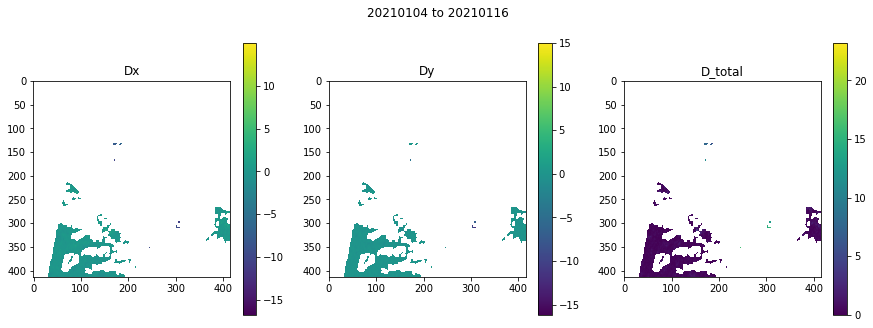

Write Outputs Start!!!
Offset.mat written.
Offset.tif written.
Velocity.tif written.
Write Outputs Done!!!
0.06304502487182617


In [20]:
# run autoRIFT with function
run_autoRIFT_inhouse(out_path, img_type, mpflag, xGrid, yGrid, indir_m, indir_s, # required parameters
                         FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATE, OVERSAMPLE_RATIO, MINCHIPSIZE,
                         Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
                         noDataMask, nodata, geogrid_run_info)

# 5) Run geogrid and autoRIFT on all images in a folder w/ multiple chip sizes

In [ ]:
import pandas as pd

s2path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel2/' # input S2 images
LS8path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/LS8images/useable_images/' # input LS8 images
PSpath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/Planet_test/Planet_test_all/'
S1path = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/'
# PSpath = '/Volumes/SGlacier/surge_projects/Working_clipped_2019/'
# boxpath = '/Users/surging/Documents/TG/BoxTurner/BoxTurner_UTM_07.shp' # the shapefile for Turner
# autoriftpath = '/Users/surging/Documents/TG/autoRIFT/' # path to the autorift scripts
# vmap_path = '/Users/surging/Documents/TG/vmap_test/' # output velocity map folder
# basepath = '/Users/surging/Documents/TG/optical-offset-tracking/' # path where this script is located

######### Set minimum and maximum time separation and the platform (L8, S2, PS, S1) ###############
platform = 'L8'
startdate = '20130101' # inclusive start date
enddate = '20160101' # inclusive end date
min_dt = 3 # minimum time separation between images
max_dt = 30 # maximum time separation between images
###############################################################################################

In [ ]:
# assign the folder path based on the platform
if platform == 'S2': # sentinel-2
    path = s2path
    ext = '_clipped.tif' # image filename extension
    img_type = 'OPT'
    date_split_idx = 2 # split filename by underscore, index corresponds to image date
elif platform == 'L8': # landsat 8
    path = LS8path
    ext = '.TIF'
    img_type = 'OPT'
    date_split_idx = 3
elif platform == 'PS': # PlanetScope
    path = PSpath
    ext = '_clipped.tif' 
    img_type = 'OPT'
    date_split_idx = 1
elif platform == 'S1': # sentinel-1
    path = S1path
    ext = '.zip' 
    img_type = 'SAR'
    date_split_idx = 5
else:
    print('Platform', platform, 'not recognized. Options are "S2", "L8", "PS", and "S1"')

# record all possible images and their dates
dates = []; files = []  
for file in os.listdir(path):
    if file.endswith(ext):
        date = file.split('_')[date_split_idx] # grab the date from the filename
        if platform == 'S1': # S1 filenames need another split
            date = date[:8]
        dates.append(date); files.append(file) # store the date and filename
files_df = pd.DataFrame(list(zip(files,dates)),columns=['filename','date'])
files_df = files_df.sort_values(by='date',ignore_index=True) # sort the dataframe by ascending date
files_df

In [ ]:
# filter out those before and afte the input start and end date
files_df = files_df[(files_df.date >= startdate) & (files_df.date <= enddate)]
files_df = files_df.reset_index(drop=True) # reset index for searching
files_df

In [ ]:
########## PARAMETERS FOR GEOGRID #################################################### 
out_path = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_AutoRIFT/' # output file path
dem = dempath+dem_outfile # path to the resampled DEM produced in the previous step (outfile name)
#             MINCHIPSIZE = CHIPSIZE_M # smallest chip size allowed in image horizontal direction (in m)
#             print(MINCHIPSIZE)
NO_DATA_VAL = -32767 # no data value in the output products
temp_dir = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/sentinel1/coreg_files/'

# PARAMETERS FOR AUTORIFT CHOSEN
# options are HPS (high pass), WAL (wallis), SOB (sobel), DB (logarithmic operator)
FILTER = 'HPS'
WALLISFILTERWIDTH = 32 # only for wallis filter, must be a power of 2

# Sampling:
SPARSE_SEARCH_SAMPLE_RATE = 16 # how many samples to skip to speed up processing
OVERSAMPLE_RATIO = 0 # enter in a constant scalar or 0 for default parameters
print('Filters and autoRIFT sample rates chosen.')
############################################################################################

In [ ]:
######### ENTER DEM INFO, AND REFERENCE VELOCITY INFO ########### 
# enter in the path to your best DEM over the region
dempath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/DEMs_previous/'
demname = 'IfSAR_5m_DSM_clipped.tif'

# path to the reference files for geogrid (vx, vy, ssm)
refvpath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/' 
vx_fname = 'vx_cropped.tif' # name of reference vx file
vy_fname = 'vy_cropped.tif' # name of reference vy file

sr_scaling = 16 # multiply by vx and vy to generate search range limits
############################################################################

In [ ]:
# try multiple chip sizes and sats
for platform in ['S2','L8']:
    # assign the folder path based on the platform
    if platform == 'S2': # sentinel-2
        path = s2path
        ext = '_clipped.tif' # image filename extension
        img_type = 'OPT'
        date_split_idx = 2 # split filename by underscore, index corresponds to image date
    elif platform == 'L8': # landsat 8
        path = LS8path
        ext = '.TIF'
        img_type = 'OPT'
        date_split_idx = 3
    elif platform == 'PS': # PlanetScope
        path = PSpath
        ext = '_clipped.tif' 
        img_type = 'OPT'
        date_split_idx = 1
    elif platform == 'S1': # sentinel-1
        path = S1path
        ext = '.zip' 
        img_type = 'SAR'
        date_split_idx = 5
    else:
        print('Platform', platform, 'not recognized. Options are "S2", "L8", "PS", and "S1"')

    # record all possible images and their dates
    dates = []; files = []  
    for file in os.listdir(path):
        if file.endswith(ext):
            date = file.split('_')[date_split_idx] # grab the date from the filename
            if platform == 'S1': # S1 filenames need another split
                date = date[:8]
            dates.append(date); files.append(file) # store the date and filename
    files_df = pd.DataFrame(list(zip(files,dates)),columns=['filename','date'])
    files_df = files_df.sort_values(by='date',ignore_index=True) # sort the dataframe by ascending date
    files_df = files_df[(files_df.date >= startdate) & (files_df.date <= enddate)]
    files_df = files_df.reset_index(drop=True) # reset index for searching
    
    for min_chipsize in [100,160,200,300]: # MULTIPLE CHIP SIZES
        MINCHIPSIZE = min_chipsize
        # generate geogrid inputs and grab outfilenames
        [dem_outfile, dhdx_outfile, dhdy_outfile, 
         vx_outfile, vy_outfile, srx_outfile, 
         sry_outfile, ssm_outfile, tg_outfile] = generate_geogrid_inputs(min_chipsize, dempath, demname, 
                                                                         refvpath, vx_fname, vy_fname, 
                                                                         sr_scaling)
        #######################################################################
        # # CHOOSE OPTIONAL INPUTS: (set as '' to leave blank)
        # # 1) surface slope:
        #   dhdx = ''; dhdy = ''  
        dhdx = dempath+dhdx_outfile; dhdy = dempath+dhdy_outfile
        
        # # 2) reference velocity:
        vx = ''; vy = ''    
#         vx = refvpath+vx_outfile; vy = refvpath+vy_outfile
        
        # # 3) chip sizes:
        csminx = ''; csminy = ''
        csmaxx = ''; csmaxy = ''  
        #             csminx = refvpath+csminx_fname; csminy = refvpath+csminy_fname
        #             csmaxx = refvpath+csmaxx_fname; csmaxy = refvpath+csmaxy_fname
        
        # # 4) stable surface mask:
        ssm = ''
        #             ssm = refvpath+ssm_outfile # stable surface mask 
        
        # # 5) search range limit:
        srx = ''; sry = '' # for best results, never input search range limit
        #######################################################################
        
        for rownum in range(0,len(files_df)-1):
            if rownum == 0: # for the first row, idx1 = 0 and idx2 = 1
                idx1 = rownum
            idx2 = idx1+1 # reset index 2 as the next item 

            if idx1 < len(files_df) and idx2 < len(files_df): # don't surpass the end of the data
                # identify the successive image pairs:
                m = files_df.loc[idx1,'filename']; s = files_df.loc[idx2, 'filename']

                # grab the two dates and convert to datetime objects
                d1s = m.split('_')[date_split_idx]; d2s = s.split('_')[date_split_idx]
                if platform == 'S1': # S1 filenames need another split
                    d1s = d1s[:8]; d2s = d2s[:8]
                
                # Skip if output already exists for this combination of parameters
#                 if os.path.exists(out_path+'offset_'+d1s+'_'+d2s+'_'+str(min_chipsize)+'m_'+platform+'.tif'):
#                     print('offset_'+d1s+'_'+d2s+'_'+str(min_chipsize)+'m_'+platform+'.tif already exists.')
#                 else:
                if True:
                    # calculate time separation
                    d1 = datetime.datetime.strptime(d1s, '%Y%m%d'); d2 = datetime.datetime.strptime(d2s, '%Y%m%d')
                    dt = d2-d1; dt = int(dt.days)

                    # evaluate if dates are within the appropriate time separation
                    while (dt < min_dt or dt > max_dt): # dt is outside of appropriate time separation
                        idx2 += 1 # increment index 2

                        if idx2 > len(files_df)-1:
                            print('No image pair with correct time separation found. Skip to next.')
                            idx2 = idx1+1 # reset index 2 as the next item 
                            m = None; s = None
                            break

                        # Keep looking for the correct time separation:
                        m = files_df.loc[idx1,'filename']; s = files_df.loc[idx2, 'filename']

                        # grab the two dates and convert to datetime objects
                        d1s = m.split('_')[date_split_idx]; d2s = s.split('_')[date_split_idx]
                        if platform == 'S1': # S1 filenames need another split
                            d1s = d1s[:8]; d2s = d2s[:8]
                        d1 = datetime.datetime.strptime(d1s, '%Y%m%d'); d2 = datetime.datetime.strptime(d2s, '%Y%m%d')
                        dt = d2-d1; dt = int(dt.days)

                    # run geogrid and autoRIFT
                    if m is not None and s is not None:
                        print(m,s)
                        indir_m = path+m; indir_s = path+s # path to the two images
                        dem = dempath+'IfSAR_'+str(MINCHIPSIZE)+'m_DSM_clipped.tif'
                        dhdx = dempath+'IfSAR_'+str(MINCHIPSIZE)+'m_DSM_clipped_dhdx.tif'
                        dhdy = dempath+'IfSAR_'+str(MINCHIPSIZE)+'m_DSM_clipped_dhdy.tif'
                        ###################### RUN GEOGRID ################################
                        run_geogrid_inhouse(out_path, img_type, indir_m, indir_s, MINCHIPSIZE, NO_DATA_VAL, dem, # required inputs
                                            dhdx, dhdy, vx, vy, srx, sry, csminx, csminy, csmaxx, csmaxy, ssm, # optional inputs
                                            temp_dir)

                        ##################### PREP AUTORIFT ##############################
                        gp = out_path # identify files produced from geogrid
                        # remove all empty grids
                        for grid in os.listdir(gp): 
                            if grid.startswith('window') and grid.endswith('.tif'):
                                reader = rio.open(gp+grid) # read dataset
                                data_found = False 
                                for band in range(1,reader.count+1):
                                    testband = reader.read(band) # read in the band
                                    if np.count_nonzero(testband[testband != NO_DATA_VAL]) > 0:
                                        data_found = True
                                if not data_found:
                                    print(grid, 'has no data. Removed.')
                                    os.remove(gp+grid)

                        # fill in AutoRIFT parameters using the files
                        mpflag = 0 # leave multiprocessing off

                        # GRID LOCATION (required) from window_location.tif
                        grid_location = rio.open(gp+'window_location.tif')
                        xGrid = grid_location.read(1) # 1st band in window location
                        yGrid = grid_location.read(2) # 2nd band in window location

                        # optional parameters (default None or zero until filled)
                        init_offset = None; search_range = None
                        chip_size_min = None; chip_size_max = None
                        offset2vx = None; offset2vy = None; stable_surface_mask = None
                        Dx0 = None; Dy0 = None; CSMINx0 = None
                        SRx0 = None; SRy0 = None;
                        CSMAXx0 = None; CSMAXy0 = None; SSM = None
                        noDataMask = np.zeros(xGrid.shape).astype(int)

                        if os.path.exists(gp+'window_offset.tif'): # Dx0 and Dy0 from window_offset.tif
                            init_offset = rio.open(gp+'window_offset.tif')
                            Dx0 = init_offset.read(1); Dy0 = init_offset.read(2)
                        if os.path.exists(gp+'window_search_range.tif'): # SRx0 and SRy0 from window_search_range.tif
                            search_range = rio.open(gp+'window_search_range.tif')
                            SRx0 = search_range.read(1); SRy0 = search_range.read(2)
                        if os.path.exists(gp+'window_chip_size_min.tif'): # CSMINx0 and CSMINy0 from window_chip_size_min.tif
                            chip_size_min = rio.open(gp+'window_chip_size_min.tif')
                            CSMINx0 = chip_size_min.read(1); CSMINy0 = chip_size_min.read(2)
                        if os.path.exists(gp+'window_chip_size_max.tif'): # CSMAXx0 and CSMAXy0 from window_chip_size_max.tif
                            chip_size_max = rio.open(gp+'window_chip_size_max.tif')
                            CSMAXx0 = chip_size_max.read(1); CSMAXy0 = chip_size_max.read(2)
                        if os.path.exists(gp+'window_rdr_off2vel_x_vec.tif'): # offset2vx from window_rdr_off2vel_x_vec.tif
                            offset2vx = gp+'window_rdr_off2vel_x_vec.tif' # path to be read in with GDAL
                        if os.path.exists(gp+'window_rdr_off2vel_y_vec.tif'): # offset2vy from window_rdr_off2vel_y_vec.tif
                            offset2vy = gp+'window_rdr_off2vel_y_vec.tif' 
                        if os.path.exists(gp+'window_stable_surface_mask.tif'): # noDataMask from window_stable_surface_mask.tif
                            stable_surface_mask = rio.open(gp+'window_stable_surface_mask.tif')
                            noDataMask = stable_surface_mask.read(1)

                        # other parameters
                        nodata = NO_DATA_VAL # use same as in previous steps
                        geogrid_run_info=None
                        print('AutoRIFT parameters loaded.')

                        ##################### RUN AUTORIFT ##############################
                        # run autoRIFT with function
                        run_autoRIFT_inhouse(out_path, img_type, mpflag, xGrid, yGrid, # required parameters
                                                 FILTER, WALLISFILTERWIDTH, SPARSE_SEARCH_SAMPLE_RATE, 
                                                 OVERSAMPLE_RATIO, MINCHIPSIZE,
                                                 Dx0, Dy0, CSMINx0, SRx0, SRy0, CSMAXx0, CSMAXy0, SSM, # optional parameters
                                                 noDataMask, nodata, geogrid_run_info)

                idx1 = idx2 # set the second image index as the new first image index
                if idx2 >= len(files_df)-1:
                    print('Finished searching.')
                    break
